<a href="https://colab.research.google.com/github/nishitjain97/NLP_538_Fall_2022_Project_HaND/blob/main/GPT_Author_Sentiment_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install tensorflow
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 5.1 MB/s 
     |████████████████████████████████| 7.6 MB 58.0 MB/s 
     |████████████████████████████████| 182 kB 73.5 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import os
import time
import datetime
import random
import torch
from tqdm.notebook import tqdm
import tensorflow as tf

from torch.utils.data import Dataset, DataLoader
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import warnings

In [ ]:
def plot_dict(dict_arrays, start_step=0, step_size=1, use_title=None, points_values=False, points_round=3,
              use_xlabel=None, use_xticks=True, use_rotation_xticks=0, xticks_labels=None, use_ylabel=None,
              style_sheet='ggplot', use_grid=True, use_linestyles=None, font_size=None, width=3, height=1, magnify=1.2,
              use_dpi=50, path=None, show_plot=True):
    r"""
    Create plot from a single array of values.
    Arguments:
        dict_arrays (:obj:`dict([list])`):
            Dictionary of arrays that will get plotted. The keys in dictionary are used as labels and the values as
            arrays that get plotted.
        start_step (:obj:`int`, `optional`, defaults to :obj:`0`):
            Starting value of plot.This argument is optional and it has a default value attributed inside
            the function.
        step_size (:obj:`int`, `optional`, defaults to :obj:`q`):
            Steps shows on x-axis. Change if each steps is different than 1.This argument is optional and it has a
            default value attributed inside the function.
        use_title (:obj:`int`, `optional`):
            Title on top of plot. This argument is optional and it will have a `None` value attributed
            inside the function.
        points_values (:obj:`bool`, `optional`, defaults to :obj:`False`):
            Display each point value on the plot. This argument is optional and it has a default value attributed
            inside the function.
        points_round (:obj:`int`, `optional`, defaults to :obj:`1`):
            Round decimal valus for points values. This argument is optional and it has a default value attributed
            inside the function.
        use_xlabel (:obj:`str`, `optional`):
            Label to use for x-axis value meaning. This argument is optional and it will have a `None` value attributed
            inside the function.
        use_xticks (:obj:`bool`, `optional`, defaults to :obj:`True`):
            Display x-axis tick values (the values at each point). This argument is optional and it has a default
            value attributed inside the function.
        use_ylabel (:obj:`str`, `optional`):
            Label to use for y-axis value meaning. This argument is optional and it will have a `None` value attributed
            inside the function.
        style_sheet (:obj:`str`, `optional`, defaults to :obj:`ggplot`):
            Style of plot. Use plt.style.available to show all styles. This argument is optional and it has a default
            value attributed inside the function.
        use_grid (:obj:`bool`, `optional`, defaults to :obj:`True`):
            Show grid on plot or not. This argument is optional and it has a default value attributed inside
            the function.
        use_linestyles (:obj:`str`, `optional`, defaults to :obj:`-`):
            Style to use on line from ['-', '--', '-.', ':']. This argument is optional and it has a default
            value attributed inside the function.
        font_size (:obj:`int` or `float`, `optional`):
            Font size to use across the plot. By default this function will adjust font size depending on `magnify`
            value. If this value is set, it will ignore the `magnify` recommended font size. The title font size is by
            default `1.8` greater than font-size. This argument is optional and it will have a `None` value attributed
            inside the function.
        width (:obj:`int`, `optional`, defaults to :obj:`3`):
            Horizontal length of plot. This argument is optional and it has a default value attributed inside
            the function.
        height (:obj:`int`, `optional`, defaults to :obj:`1`):
            Height length of plot in inches. This argument is optional and it has a default value attributed inside
            the function.
        magnify (:obj:`float`, `optional`, defaults to :obj:`0.1`):
            Ratio increase of both with and height keeping the same ratio size. This argument is optional and it has a
            default value attributed inside the function.
        use_dpi (:obj:`int`, `optional`, defaults to :obj:`50`):
            Print resolution is measured in dots per inch (or “DPI”). This argument is optional and it has a default
            value attributed inside the function.
        path (:obj:`str`, `optional`):
            Path and file name of plot saved as image. If want to save in current path just pass in the file name.
            This argument is optional and it will have a None value attributed inside the function.
        show_plot (:obj:`bool`, `optional`, defaults to :obj:`1`):
            if you want to call `plt.show()`. or not (if you run on a headless server). This argument is optional and
            it has a default value attributed inside the function.
    Raises:
        ValueError: If `dict_arrays` is not of type `dictionary`.
        ValueError: If `dict_arrays` doesn't have string keys.
        ValueError: If `dict_arrays` doesn't have array values.
        ValueError: If `style_sheet` is not valid.
        ValueError: If `use_linestyle` is not valid.
        ValueError: If `points_values`of type list don't have same length as `dict_arrays`.
        DeprecationWarning: If `magnify` is se to values that don't belong to [0, 1] values.
        ValueError: If `font_size` is not `None` and smaller or equal to 0.
    """
    # Magnify intervals where font size matters
    MAGNIFY_INTERVALS = [0.1, 1]

    # Min and max appropriate font sizes
    FONT_RANGE = [10.5, 50]

    # Maximum allowed magnify. This will get multiplied by 0 - 1 value.
    MAX_MAGNIFY = 15

    # Increase font for title ratio.
    TITLE_FONT_RATIO = 1.8

    # Check if `dict_arrays` is the correct format.
    if not isinstance(dict_arrays, dict):
        # Raise value error.
        raise ValueError("`dict_arrays` needs to be a dictionary of values!")

    # Check each label
    for label, array in dict_arrays.items():
        # Check if format is correct.
        if not isinstance(label, str):
            # Raise value error.
            raise ValueError("`dict_arrays` needs string keys!")
        if not isinstance(array, list) or isinstance(array, np.ndarray):
            # Raise value error.
            raise ValueError("`dict_arrays` needs lists values!")

    # Make sure style sheet is correct.
    if style_sheet in plt.style.available:
        # Set style of plot
        plt.style.use(style_sheet)
    else:
        # Style is not correct.
        raise ValueError("`style_sheet=%s` is not in the supported styles: %s" % (str(style_sheet),
                                                                                  str(plt.style.available)))

    # Make sure `magnify` is in right range.
    if magnify > 1 or magnify <= 0:
        # Deprecation warning from last time.
        warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',
                      DeprecationWarning)
        # Convert to regular value 0.1.
        magnify = 0.1

    # all linestyles.
    linestyles = ['-', '--', '-.', ':']

    # Make sure `font_size` is set right.
    if (font_size is not None) and (font_size <= 0):
        # Raise value error -  is not correct.
        raise ValueError(f'`font_size` needs to be positive number! Invalid value {font_size}')

    # Font size select custom or adjusted on `magnify` value.
    font_size = font_size if font_size is not None else np.interp(magnify, MAGNIFY_INTERVALS, FONT_RANGE)

    # Font variables dictionary. Keep it in this format for future updates.
    font_dict = dict(
        family='DejaVu Sans',
        color='black',
        weight='normal',
        size=font_size,
    )

    # If single style value is passed, use it on all arrays.
    if use_linestyles is None:
        use_linestyles = ['-'] * len(dict_arrays)

    else:
        # Check if linestyle is set right.
        for use_linestyle in use_linestyles:
            if use_linestyle not in linestyles:
                # Raise error.
                raise ValueError("`linestyle=%s` is not in the styles: %s!" % (str(use_linestyle), str(linestyles)))

    # Check `points_value` type - it can be bool or list(bool).
    if isinstance(points_values, bool):
        # Convert to list.
        points_values = [points_values] * len(dict_arrays)
    elif isinstance(points_values, list) and (len(points_values) != len(dict_arrays)):
        raise ValueError('`points_values` of type `list` must have same length as dictionary!')

    # Single plot figure.
    plt.subplot(1, 2, 1)

    # Use maximum length of steps. In case each arrya has different lengths.
    max_steps = []

    # Plot each array.
    for index, (use_label, array) in enumerate(dict_arrays.items()):
        # Set steps plotted on x-axis - we can use step if 1 unit has different value.
        if start_step > 0:
            # Offset all steps by start_step.
            steps = np.array(range(0, len(array))) * step_size + start_step
            max_steps = steps if len(max_steps) < len(steps) else max_steps
        else:
            steps = np.array(range(1, len(array) + 1)) * step_size
            max_steps = steps if len(max_steps) < len(steps) else max_steps

        # Plot array as a single line.
        plt.plot(steps, array, linestyle=use_linestyles[index], label=use_label)

        # Plots points values.
        if points_values[index]:
            # Loop through each point and plot the label.
            for x, y in zip(steps, array):
                # Add text label to plot.
                plt.text(x, y, str(round(y, points_round)), fontdict=font_dict)

    # Set horizontal axis name.
    plt.xlabel(use_xlabel, fontdict=font_dict)

    # Use x ticks with steps or labels.
    plt.xticks(max_steps, xticks_labels, rotation=use_rotation_xticks) if use_xticks else None

    # Set vertical axis name.
    plt.ylabel(use_ylabel, fontdict=font_dict)

    # Adjust both axis labels font size at same time.
    plt.tick_params(labelsize=font_dict['size'])

    # Place legend best position.
    plt.legend(loc='best', fontsize=font_dict['size'])

    # Adjust font for title.
    font_dict['size'] *= TITLE_FONT_RATIO

    # Set title of figure.
    plt.title(use_title, fontdict=font_dict)

    # Rescale `magnify` to be used on inches.
    magnify *= MAX_MAGNIFY

    # Display grid depending on `use_grid`.
    plt.grid(use_grid)

    # Make figure nice.
    plt.tight_layout()

    # Get figure object from plot.
    fig = plt.gcf()

    # Get size of figure.
    figsize = fig.get_size_inches()

    # Change size depending on height and width variables.
    figsize = [figsize[0] * width * magnify, figsize[1] * height * magnify]

    # Set the new figure size with magnify.
    fig.set_size_inches(figsize)

    # There is an error when DPI and plot size are too large!
    try:
        # Save figure to image if path is set.
        fig.savefig(path, dpi=use_dpi, bbox_inches='tight') if path is not None else None
    except ValueError:
        # Deprecation warning from last time.
        warnings.warn(f'`magnify={magnify // 15}` is to big in combination'
                      f' with `use_dpi={use_dpi}`! Try using lower values for'
                      f' `magnify` and/or `use_dpi`. Image was saved in {path}'
                      f' with `use_dpi=50 and `magnify={magnify // 15}`!', Warning)
        # Set DPI to smaller value and warn user to use smaller magnify or smaller dpi.
        use_dpi = 50
        # Save figure to image if path is set.
        fig.savefig(path, dpi=use_dpi, bbox_inches='tight') if path is not None else None

    # Show plot.
    plt.show() if show_plot is True else None

    return

In [ ]:
data_path = "/content/gdrive/MyDrive/NLP_Project/"
data = {}

for item in ['train', 'dev', 'random_test', 'fixed_test']:
  data[item] = pd.read_csv(os.path.join(data_path, item + '.txt'))

In [ ]:
# Set seed for reproducibility.
set_seed(123)

# Number of training epochs (authors on fine-tuning Bert recommend between 2 and 4).
epochs = 4

# Look for gpu to use. Will use `cpu` by default if no gpu found.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Name of transformers model - will use already pretrained model.
# Path of transformer model - will load your own model from local disk.
model_name_or_path = 'gpt2'

# Dictionary of labels and their id - this will be used to convert.
# String labels to number ids.
labels_ids = {'Negative': 0, 'Neutral': 1, 'Positive': 2}

# How many labels are we using in training.
# This is used to decide size of classification head.
n_labels = len(labels_ids)

In [ ]:
class CustomDataset(Dataset):
  r"""PyTorch Dataset class for loading data.

  This is where the data parsing happens.

  This class is built with reusability in mind: it can be used as is as.

  Arguments:

    path (:obj:`str`):
        Path to the data partition.

  """

  def __init__(self, data, use_tokenizer):
    self.texts = data['MASKED_DOCUMENT']
    self.labels = data['TRUE_SENTIMENT']

    # Number of exmaples.
    self.n_examples = len(self.labels)
    return

  def __len__(self):
    r"""When used `len` return the number of examples.

    """
    
    return self.n_examples

  def __getitem__(self, item):
    r"""Given an index return an example from the position.
    
    Arguments:

      item (:obj:`int`):
          Index position to pick an example to return.

    Returns:
      :obj:`Dict[str, str]`: Dictionary of inputs that contain text and 
      asociated labels.

    """

    return {'text':self.texts[item],
            'label':self.labels[item]}

In [ ]:
class Gpt2ClassificationCollator(object):
    r"""
    Data Collator used for GPT2 in a classificaiton rask. 
    
    It uses a given tokenizer and label encoder to convert any text and labels to numbers that 
    can go straight into a GPT2 model.

    This class is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

    Arguments:

      use_tokenizer (:obj:`transformers.tokenization_?`):
          Transformer type tokenizer used to process raw text into numbers.

      labels_ids (:obj:`dict`):
          Dictionary to encode any labels names into numbers. Keys map to 
          labels names and Values map to number associated to those labels.

      max_sequence_len (:obj:`int`, `optional`)
          Value to indicate the maximum desired sequence to truncate or pad text
          sequences. If no value is passed it will used maximum sequence size
          supported by the tokenizer and model.

    """

    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):

        # Tokenizer to be used inside the class.
        self.use_tokenizer = use_tokenizer
        # Check max sequence length.
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        # Label encoder used inside the class.
        self.labels_encoder = labels_encoder

        return

    def __call__(self, sequences):
        r"""
        This function allowes the class objesct to be used as a function call.
        Sine the PyTorch DataLoader needs a collator function, I can use this 
        class as a function.

        Arguments:

          item (:obj:`list`):
              List of texts and labels.

        Returns:
          :obj:`Dict[str, object]`: Dictionary of inputs that feed into the model.
          It holddes the statement `model(**Returned Dictionary)`.
        """

        # Get all texts from sequences list.
        texts = [sequence['text'] for sequence in sequences]
        # Get all labels from sequences list.
        labels = [sequence['label'] for sequence in sequences]
        # Encode all labels using label encoder.
        labels = [self.labels_encoder[label] for label in labels]
        # Call tokenizer on all texts to convert into tensors of numbers with 
        # appropriate padding.
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        # Update the inputs with the associated encoded labels as tensor.
        inputs.update({'labels':torch.tensor(labels)})

        return inputs

In [ ]:
def train(dataloader, optimizer_, scheduler_, device_):
  r"""
  Train pytorch model on a single pass through the data loader.

  It will use the global variable `model` which is the transformer model 
  loaded on `_device` that we want to train on.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

  Arguments:

      dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

      optimizer_ (:obj:`transformers.optimization.AdamW`):
          Optimizer used for training.

      scheduler_ (:obj:`torch.optim.lr_scheduler.LambdaLR`):
          PyTorch scheduler.

      device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:

      :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss].
  """

  # Use global variable for model.
  global model

  # Tracking variables.
  predictions_labels = []
  true_labels = []
  # Total loss for this epoch.
  total_loss = 0

  # Put the model into training mode.
  model.train()

  # For each batch of training data...
  for batch in tqdm(dataloader, total=len(dataloader)):

    # Add original labels - use later for evaluation.
    true_labels += batch['labels'].numpy().flatten().tolist()
    
    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    
    # Always clear any previously calculated gradients before performing a
    # backward pass.
    model.zero_grad()

    # Perform a forward pass (evaluate the model on this training batch).
    # This will return the loss (rather than the model output) because we
    # have provided the `labels`.
    # The documentation for this a bert model function is here: 
    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
    outputs = model(**batch)

    # The call to `model` always returns a tuple, so we need to pull the 
    # loss value out of the tuple along with the logits. We will use logits
    # later to calculate training accuracy.
    loss, logits = outputs[:2]

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. `loss` is a Tensor containing a
    # single value; the `.item()` function just returns the Python value 
    # from the tensor.
    total_loss += loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer_.step()

    # Update the learning rate.
    scheduler_.step()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Convert these logits to list of predicted labels values.
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)
  
  # Return all true labels and prediction for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss



def validation(dataloader, device_):
  r"""Validation function to evaluate model performance on a 
  separate set of data.

  This function will return the true and predicted labels so we can use later
  to evaluate the model's performance.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

  Arguments:

    dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

    device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:
    
    :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss]
  """

  # Use global variable for model.
  global model

  # Tracking variables
  predictions_labels = []
  true_labels = []
  #total loss for this epoch.
  total_loss = 0

  # Put the model in evaluation mode--the dropout layers behave differently
  # during evaluation.
  model.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):

    # add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(**batch)

        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple along with the logits. We will use logits
        # later to to calculate training accuracy.
        loss, logits = outputs[:2]
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()
        
        # get predicitons to list
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss

In [ ]:
# Get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

Loading configuraiton...


Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
# default to left padding
tokenizer.padding_side = "right"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token

Loading tokenizer...


Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [ ]:
# Get the actual model.
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

Loading model...


Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))
# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id


# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

Model loaded to `cuda`


In [ ]:
MAX_LENGTH = 512

In [ ]:
# Create data collator to encode text and labels into numbers.
gpt2_classification_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=MAX_LENGTH)

In [ ]:
batch_sizes = {
    'train': 8,
    'dev': 4,
    'random_test': 4,
    'fixed_test': 4
}

In [ ]:
dataset = {}
dataloaders = {}

for key in data.keys():
  dataset[key] = CustomDataset(data[key], use_tokenizer=tokenizer)
  dataloaders[key] = DataLoader(dataset[key], batch_size=batch_sizes[key], shuffle=True, collate_fn=gpt2_classification_collator)

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )

In [ ]:
NUM_TRAIN_EPOCHS = 4
WARMUP_PROPORTION = 0.1

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(dataloaders['train']) * NUM_TRAIN_EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = int(total_steps * WARMUP_PROPORTION), # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

In [ ]:
# Loop through each epoch
for epoch in tqdm(range(NUM_TRAIN_EPOCHS)):
  print()
  print("Training on batches...")
  # Perform one full pass over the training set
  train_labels, train_predict, train_loss = train(dataloaders['train'], optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)
  
  print("Validation on batches...")
  valid_labels, valid_predict, val_loss = validation(dataloaders['dev'], device)
  val_acc = accuracy_score(valid_labels, valid_predict)

  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

  0%|          | 0/4 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/420 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/145 [00:00<?, ?it/s]

  train_loss: 1.50360 - val_loss: 0.91593 - train_acc: 0.50492 - valid_acc: 0.58997


Training on batches...


  0%|          | 0/420 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/145 [00:00<?, ?it/s]

  train_loss: 0.85471 - val_loss: 0.93957 - train_acc: 0.59553 - valid_acc: 0.52595


Training on batches...


  0%|          | 0/420 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/145 [00:00<?, ?it/s]

  train_loss: 0.76818 - val_loss: 0.93115 - train_acc: 0.64590 - valid_acc: 0.55709


Training on batches...


  0%|          | 0/420 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/145 [00:00<?, ?it/s]

  train_loss: 0.68171 - val_loss: 1.00373 - train_acc: 0.69657 - valid_acc: 0.55882



<ipython-input-4-980f90172f05>:116: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


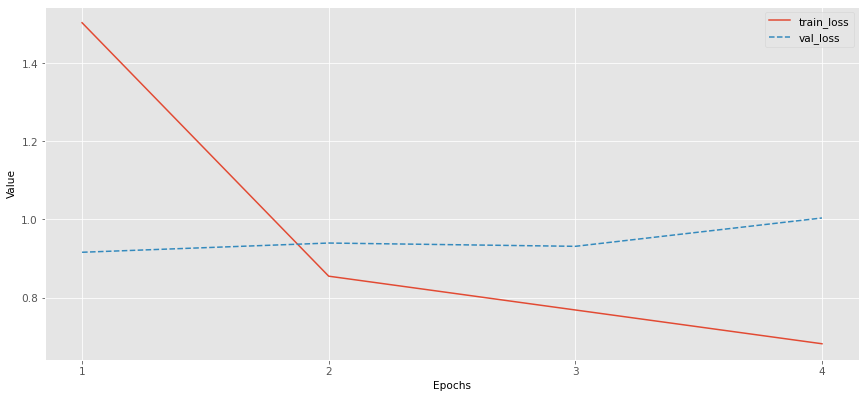

<ipython-input-4-980f90172f05>:116: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


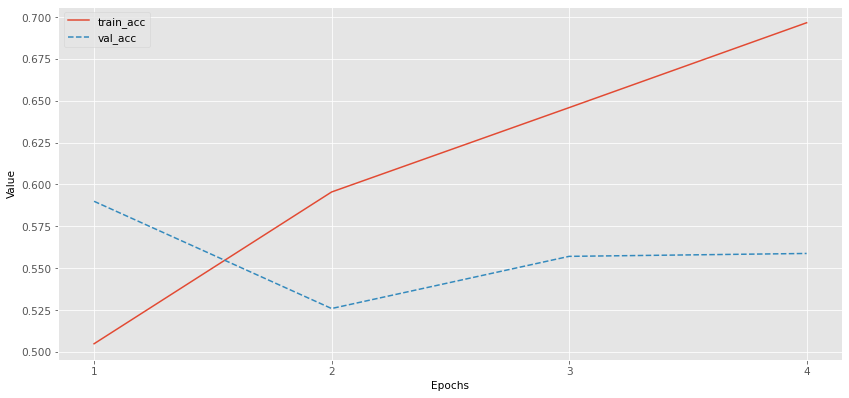

In [ ]:
# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

In [ ]:
print("Random test set...")
labels, predictions, loss = validation(dataloaders['random_test'], device)
acc = accuracy_score(labels, predictions)

Random test set...


  0%|          | 0/145 [00:00<?, ?it/s]

In [ ]:
acc

0.5664939550949913

In [ ]:
print("Fixed test set...")
labels, predictions, loss = validation(dataloaders['fixed_test'], device)
acc = accuracy_score(labels, predictions)

Fixed test set...


  0%|          | 0/207 [00:00<?, ?it/s]

In [ ]:
acc

0.5042321644498187

In [ ]:
import os
output_dir = '/content/gdrive/MyDrive/NLP_Project/gpt_save/'

if not os.path.exists(output_dir):
  os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to /content/gdrive/MyDrive/NLP_Project/gpt_save/


('/content/gdrive/MyDrive/NLP_Project/gpt_save/tokenizer_config.json',
 '/content/gdrive/MyDrive/NLP_Project/gpt_save/special_tokens_map.json',
 '/content/gdrive/MyDrive/NLP_Project/gpt_save/vocab.json',
 '/content/gdrive/MyDrive/NLP_Project/gpt_save/merges.txt',
 '/content/gdrive/MyDrive/NLP_Project/gpt_save/added_tokens.json')